[Reference](https://medium.com/@dreamferus/the-powerful-feature-extraction-method-youve-never-heard-of-1e960483e709)

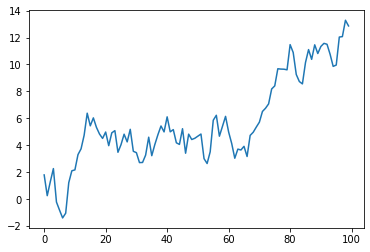

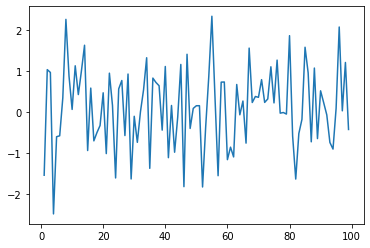

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = pd.Series(np.random.normal(size=100).cumsum())
x.plot()
plt.show()
x.diff().plot()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

def find_difference_order(x, significance_level=0.05):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    for i in range(3):
        if i > 0:
            x = x.diff().dropna()
        p_value = adfuller(x)[1]
        if p_value < significance_level:
            return i
    return None
        
find_difference_order(x)

1

In [8]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [9]:
[find_difference_order(x) for x in x_train[:10]]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [5]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 22.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [10]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from tqdm.auto import tqdm

# find the best lag for one time series
def _get_best_lag(x, maxlag):
    return max(ar_select_order(x, maxlag, ic="aic").ar_lags)

# find the average best lag
# for the time series
def find_best_lag(x, maxlag=100):
    lags = []
    for i in tqdm(range(len(x))):
        lags.append(_get_best_lag(x[i], maxlag))
    return int(round(np.mean(lags)))

# extract coefficients
def get_ar_coefficients(x, lags):
    features = []
    for i in tqdm(range(len(x))):
        ar_model = AutoReg(x[i], lags).fit()
        features.append(ar_model.params)
    return pd.DataFrame(features)

# sample every 10th to reduce computation time
best_lag = find_best_lag(x_train[::10, :])
print("Chosen lag", best_lag)
# => "Chosen lag 45"
train_features = get_ar_coefficients(x_train, best_lag)
test_features = get_ar_coefficients(x_test, best_lag)

  0%|          | 0/361 [00:00<?, ?it/s]

Chosen lag 45


  0%|          | 0/3601 [00:00<?, ?it/s]

  0%|          | 0/1320 [00:00<?, ?it/s]

In [11]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report

model = LogisticRegressionCV(max_iter=10000)
model.fit(train_features, y_train)
pd.DataFrame(classification_report(y_test, model.predict(test_features), output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.977941,0.975000,0.976515,0.976471,0.976517
recall,0.976505,0.976526,0.976515,0.976515,0.976515
f1-score,0.977223,0.975762,0.976515,0.976492,0.976516
support,681.000000,639.000000,0.976515,1320.000000,1320.000000
